# 6장 텍스트와 시퀀스를 위한 딥러닝_2
[케라스 창시자에게 배우는 딥러닝] 책을 기반으로 제가 정리하고 요약한 내용입니다.  
저번에 이어서 오늘은 6.3절부터 6장 끝까지 달려보겠습니다! 오늘도 어김없이 코랩에서 진행합니다.

## 6.3 순환 신경망의 고급 사용법

이 절에서는 순환 신경망의 성능과 일반화 능력을 향상시키기 위한 세 가지 고급 기술을 살펴보겟습니다. 온도 예측 문제로 위 기술들을 모두 시도합니다.
* 시계열 데이터
* 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터
* 마지막 데이터 포인트에서 24시간 이후의 온도 예측

세 가지 기법들입니다.
* **순환 드롭아웃(recurrent dropout)** : 순환 층에서 오버피팅을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
* **스태킹 순환 층(stacking recurrent layer)** : 네트워크 표현 능력(representational power)을 증가시킵니다(그 대신 계산 비용이 많이 듭니다).
* **양방향 순환 층(bidirectional recurrent layer)** : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.

### 6.3.1 기온 예측 문제

지금까지 다룬 시퀀스 데이터는 IMDB나 로이터 데이터셋처럼 텍스트 데이터이지만 시퀀스 데이터는 이런 언어 처리 분야뿐만 아니라 훨씬 많은 문제에 등장합니다.  
여기서는 날씨 시계열 데이터셋을 사용합니다. 이 데이터는 독일 예나시에 있는 막스 플랑크 생물지구화학 연구소의 지상 관측소에서 수집한 것입니다.

이 데이터셋에는 수년간에 걸쳐 (기온, 기압, 습도, 풍향 등) <u>14개의 관측치</u>가 <u>10분마다</u> 기록되어 있습니다.  
원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 <u>2009~2016년</u> 사이의 데이터만 사용합니다.

In [1]:
# 데이터 다운로드
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2019-08-30 01:39:14--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.132.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.132.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  36.8MB/s    in 0.4s    

2019-08-30 01:39:14 (36.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


이제 데이터를 살펴봅니다.

In [3]:
# 코드 6-28 예나의 날씨 데이터셋 조사하기

with open('./jena_climate_2009_2016.csv', 'r') as f:
  data = f.read()
  
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


헤더에는 날짜와 14개의 날씨 정보 레코드가 있습니다.  
총 데이터는 42만 551입니다. 이 데이터 전체를  넘파이 배열로 바꿉니다.

In [0]:
# 코드 6-29 데이터 파싱하기
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

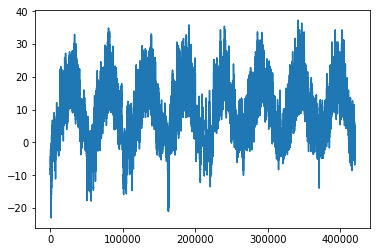

In [5]:
# 코드 6-30 시계열 온도 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline

temp = float_data[:, 1] # 온도(섭씨) - T (decC)
plt.plot(range(len(temp)), temp)

그래프를 보니 온도의 주기성이 있는것을 볼 수 있습니다.

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144(24 * 6)개의 데이터 포인트가 있습니다.

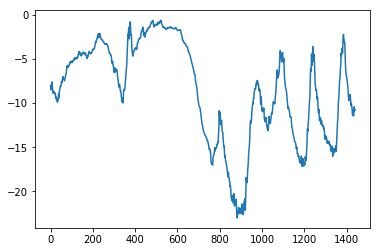

In [6]:
# 코드 6-31 처음 10일간 온도 그래프 그리기
plt.plot(range(1440), temp[:1440])

이 그래프에서는 일별 주기성을 볼 수 있습니다(특히 마지막 4일). 지난 몇달간 데이터를 사용하여 다음 달의 평균 온도를 예측하는 문제는 데이터 주기성이 안정적이기 때문에 쉽습니다. 하지만 하루하루 데이터를 살펴보면 온도 변화는 불안정합니다. 일별 시계열 데이터를 예측할 수 있는지 확인해보죠.

### 6.3.2 데이터 준비

이 문제의 정확한 정의는 다음과 같습니다.

lookback 타임스텝만큼 이전으로 돌아가서 매 stpes 타임스텝마다 샘플링합니다. 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측할 수 있을까요?
* lookback = 1440: 10일 전 데이터로 돌아갑니다.
* steps = 6: 1시간마다 데이터 포인트 하나를 샘플링합니다.
* delay = 144: 24시간이 지난 데이터가 타깃이 됩니다.

시작하기 전에 두 가지 작업을 처리해야 합니다.
* 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지는 않지만 데이터에 있는 각 시계열 특성의 범위가 서로 달라 정규화하여야 합니다.
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제네레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다. 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용하여 그때그때 배치를 만들겠습니다.

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다.  
처음 20만 개 타임스텝을 훈련 데이터로 사용할 것이므로 20만 개만 사용합니다.

In [0]:
# 코드 6-32 데이터 정규화하기
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

아래 코드는 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 ```(samples, targets)``` 튜플을 반복적으로 반환합니다. samples는 입력 데이터로 사용할 배치고 targets는 이에 대응되는 타깃 온도의 배열입니다. 다음 매개변수가 있습니다.

* data: 정규화한 부동 소수 데이터로 이루어진 원본 배열
* lookback: 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* delay: 타깃으로 사용할 미래의 타임스텝
* min_index와 max_index: 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스, 검증 데이터와 테스트 데이터를 분리하는데 사용
* shuffle: 샘플을 섞을지, 시간 순서대로 추출할지를 결정합니다.
* batch_size: 배치의 샘플 수
* step: 데이터를 샘플링할 타임스텝 간격. 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

In [0]:
# 코드 6-33 시계열 데이터와 타깃을 반환하는 제너레이터 함수

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
          min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

이제 generator 함수를 사용하여 훈련용, 검증용, 테스트용의 3개의 제너레이터를 만듭니다. 각 제너레이터는 원본 데이터에서 다른 시간대를 사용합니다.  
훈련 제너레이터는 처음 20만 개 타임스텝을 사용하고, 검증 제너레이터는 그다음 10만 개, 테스트 제너레이터는 나머지를 사용합니다.

In [0]:
# 코드 6-34 훈련, 검증, 테스트 제너레이터 준비하기
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 6.3.3 상식 수준의 기준점

딥러닝 모델을 사용하기 전에 간단한 상식 수준의 해법을 시도해 보겠습니다.이는 정상 여부 확인을 위한 용도와 고수준 머신 러닝 모델이라면 뛰어넘어야 할 기준점을 만듭니다.

이런 상식 수준의 해법은 알려진 해결책이 없는 새로운 문제를 다루어야 할 때 유용합니다. 일부 클래스가 월등히 많아 불균형한 분류 문제가 고전적인 예입니다. 100개중에 A가 90개 B가 10개 있다면 여기서 상식 수준의 접근법은 항상 A라고 예측하는 것입니다. 정확도는 90%정도 되는데  머신 러닝 기반의 모델이라면 90% 이상을 달성해야 합니다.

이 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다. 그러므로 상식 수준의 해결책은 지금으로부터 24시간 후 온도는 지금과 동일하다고 예측하는 것입니다. 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠습니다.

In [10]:
# 코드 6-35 상식적인 기준 모델의 MAE 계산하기

def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값을 파악하기가 어렵습니다. MAE 0.29에 표준 편차를 곱하면 알 수 있습니다.

In [11]:
# 코드 6-36 MAE 섭씨 단위로 변환하기

0.29 * std[1]

2.5672247338393395

섭씨 2.57도가 됩니다. 평균 절댓값 오차가 상당히 큰 것을 알 수 있습니다. 여기서 std배열은 14개의 특성에 대한 표준 편차가 모두 기록된 넘파이 배열입니다. 온도의 인덱스는 1이기에 std[1]로 데이터를 가져올 수 있습니다.

### 6.3.4 기본적인 머신 러닝 방법

상식 수준의 기준점을 만들어 놓았습니다. RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단한 머신 러닝 모델을 먼저 만드는 것이 좋습니다. 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적 이득도 얻게 될 것입니다.

데이터를 펼쳐서 2개의 Dense 층을 통과시키는 완전 연결 네트워크입니다. 회귀 문제이므로 마지막 층에 활성화 함수를 두지 않습니다. 손실 함수는 상식 수준의 방법과 동일한 MAE 입니다.

In [12]:
# 코드 6-37 완전 연결 모델을 훈련하고 평가하기

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.
W0830 02:57:11.581550 140171971839872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 02:57:11.625423 140171971839872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 02:57:11.647483 140171971839872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 02:57:11.687877 140171971839872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 02:57:11.852250 14017197

Epoch 1/20
500/500 [==============================] - 19s 38ms/step - loss: 1.3994 - val_loss: 0.5778
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.4483 - val_loss: 0.3668
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2978 - val_loss: 0.3023
Epoch 4/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2705 - val_loss: 0.3225
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2565 - val_loss: 0.3092
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2454 - val_loss: 0.3345
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2390 - val_loss: 0.3433
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2338 - val_loss: 0.3316
Epoch 9/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2288 - val_loss: 0.3234
Epoch 10/20
500/500 [==============================] - 14s 28ms/step - loss: 0.224

훈련 손실과 검증 손실 그래프를 그립니다.

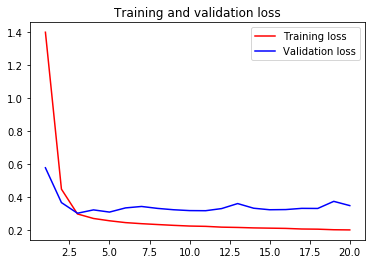

In [13]:
# 코드 6-38 결과 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

일부 검증 손실은 학습을 사용하지 않은 기준점에 가깝지만 안정적이지는 못합니다. 이 문제는 기준점을 넘기 쉽지 않습니다. 이미 적용한 상식은 기계에게는 상식이 아닌 핵심 정보가 많이 포함되어 있기 때문입니다.

왜 상식 수준보다 훈련된 모델이 성능이 낮을까요? 그 이유는 훈련 과정이 찾는 것은 간단한 모델이 아니기 때문입니다. 현재 훈련으로 학습된 모델은 매개변수로 설정한 2개의 층을 가진 네트워크의 모든 가능한 가중치 조합입니다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단한고 괜찮은 성능을 내는 모델은 찾지 못할 수 있는 것입니다. 이것이 머신 러닝이 가진 심각한 제약 사항입니다.

### 6.3.5 첫 번째 순환 신경망

첫 번째 완전 연결 네트워크는 잘 작동하지 않았습니다. 앞선 모델은 시계열 데이터를 펼쳤기 때문에 시간 개념을 잃어버렸습니다. 이제 순서가 의미 있는 시퀀스 데이터를 그대로 사용해 보겠습니다.

이전에 공부한 LSTM 층 대신 GRU 층을 사용하겠습니다. **GRU(Gated Recurrent Unit)** 층은 LSTM과 같은 원리로 작동하지만 조금 간결하고, 계산 비용이 덜 듭니다. 대신 학습 능력이 비교적 부족할 수는 있습니다.

In [14]:
# 코드 6-39 GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0830 03:13:21.018587 140171971839872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
500/500 [==============================] - 199s 399ms/step - loss: 0.2994 - val_loss: 0.2745
Epoch 2/20
500/500 [==============================] - 198s 397ms/step - loss: 0.2832 - val_loss: 0.2644
Epoch 3/20
500/500 [==============================] - 198s 397ms/step - loss: 0.2775 - val_loss: 0.2655
Epoch 4/20
500/500 [==============================] - 197s 394ms/step - loss: 0.2720 - val_loss: 0.2632
Epoch 5/20
500/500 [==============================] - 196s 392ms/step - loss: 0.2694 - val_loss: 0.2703
Epoch 6/20
500/500 [==============================] - 200s 401ms/step - loss: 0.2631 - val_loss: 0.2669
Epoch 7/20
500/500 [==============================] - 198s 397ms/step - loss: 0.2582 - val_loss: 0.2660
Epoch 8/20
500/500 [==============================] - 200s 399ms/step - loss: 0.2519 - val_loss: 0.2732
Epoch 9/20
500/500 [==============================] - 200s 401ms/step - loss: 0.2483 - val_loss: 0.2706
Epoch 10/20
500/500 [==============================] - 202s 403m

이번에도 훈련에 거의 1시간 정도 걸린 것 같습니다...ㅠ  
그래프를 그려보겠습니다.

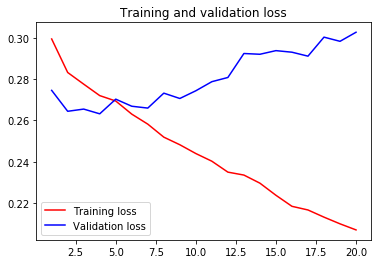

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

시퀀스를 펼쳐서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 이런 종류의 작업에 훨씬 뛰어나다는 것을 보여줍니다. 새로운 검증 MAE는 0.265이고 섭씨로 복원하면 2.35도 입니다. 초기 에러 2.57도 보다는 낫지만 이것보다 더 개선할 수 있습니다.

### 6.3.6 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

훈련 손실과 검증 손실 곡선을 보면 모델이 과대적합인지 알 수 있습니다. 이를 개선하기 위해 드롭아웃을 사용합니다. 하지만 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 층 이전에 드롭아웃을 적용하면 규제에 도움되는 것보다 학습에 더 방해되는 것으로 알려졌습니다. 

하지만 2015년 Yarin Gal의 베이지안 딥러닝에 관한 박사 논문에서 순환 신경망에서 드롭아웃을 사용하는 방법을 알아냈습니다. 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크를 모든 타임스텝에 적용해야합니다.

케라스에 있는 모든 순환 층은 2개의 드롭아웃 매개변수를 가지고 있습니다.
* dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값입니다.
* recurrent_dropout은 순환 상태의 드롭아웃 비율을 정합니다.

GRU 층에 드롭아웃과 순환 드롭아웃을 적용하겠습니다.

In [0]:
# 코드 6-40 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

이제부터는 너무 오래걸려서 실제 훈련진행은 못하고 코드를 이해하는 형식으로 진행하겠습니다 ㅠㅠ

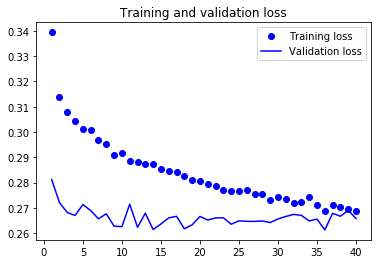

In [19]:
from IPython.display import Image
 
Image("./grudropout.png")

30번째 에포크까지 오버피팅이 일어나지 않았습니다. 평가 점수는 안정적이지만 이전보다 나아지지는 않았습니다.

### 6.3.7 스태킹 순환 층

과대 적합은 더 이상 없지만 성능상 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다. 일반적인 머신 러닝 작업 흐름을 기억하세요! (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다 가정하고) 오버피팅이 일어날 때까지 네트워크 용량을 늘리는 것이 좋습니다.

네트워크 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가합니다.

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간층은 마지막 타임스텝 출력만 아니고 전체 시퀀스(3D)를 출력해야 합니다.  
return_sequences=True로 지정하면 됩니다.


In [0]:
# 코드 6-41 드롭아웃으로 규제하고 스태킹한 GRU 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

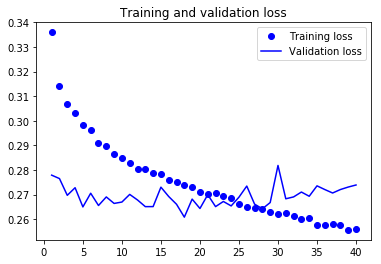

In [20]:
from IPython.display import Image
 
Image("./grustacking.png")

층을 추가하여 성능을 조금 향상시켰지만 크지는 않습니다. 여기서 두 가지 결론을 얻을 수 있습니다
* 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 계산 비용이 추가됩니다.
* 을 추가한 만큼 도움이 되지 않았으므로 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

### 6.3.8 양방향 RNN 사용하기

마지막 기법은 **양방향 RNN(bidirectional RNN)** 입니다. RNN의 한 변종이고 특정 작업에서 기본 RNN보다 훨씬 좋은 성능을 냅니다.

RNN은 순서 또는 시간에 민감합니다. 즉 입력 시퀀스의 타임스텝 순서대로 처리합니다. 타임스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어버립니다. 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용합니다. GRU나 LSTM 같은 RNN을 2개 사용합니다. 각 RNN은 각 입력을 한 방향(시간 순서나 반대 순서)으로 처리한 후 각 표현을 합칩니다. 시퀀스를 양쪽 방향으로 처리하기 때문에 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있습니다.

오래된 타임스텝이 먼저 나오도록 시퀀스를 처리하는 것(시간의 순서대로)은 근거 없는 결정입니다. 하지만 최근 타임스텝이 먼저 나오도록 입력 시퀀스를 처리하면 더 나은 결과를 만들까요?

결론부터 말하면 그렇지 않습니다. 기본적인 GRU층은 먼 과거보다 최근 내용을 더 잘 기억하기 때문입니다. 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 합니다.

하지만 자연어 처리를 포함한 다양한 문제에서는 그렇지 않습니다. 문장을 이해하는데 단어의 중요성은 위치와 크게 상관도가 없기 때문입니다.

LSTM을 거꾸로 하여 IMDB 예제에 적용해 보겠습니다.

In [0]:
# 코드 6-42 거꾸로 된 시퀀스를 사용한 LSTM을 훈련하고 평가하기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000 # 특성으로 사용할 단어의 수
maxlen = 500 # 사용할 텍스트의 길이(가장 빈번한 max_features개의 단어만 사용합니다.)

#데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다.
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다.
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 이런 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동합니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침합니다.

거꾸로 된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 다른 표현을 학습합니다. 머신 러닝에서 다른 표현이 유용하다면 항상 사용할 가치가 있습니다. 이 표현이 데이터를 바라보는 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아냅니다. 이런 표현은 작업의 성능을 올리는 데 도움을 줍니다. 이것이 다음 장에서 살펴볼 앙상블의 개념입니다.

양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을 향상시킵니다. 입력 시퀀스를 양쪽 방향으로 바라보기 때문에, 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 잡아 냅니다.

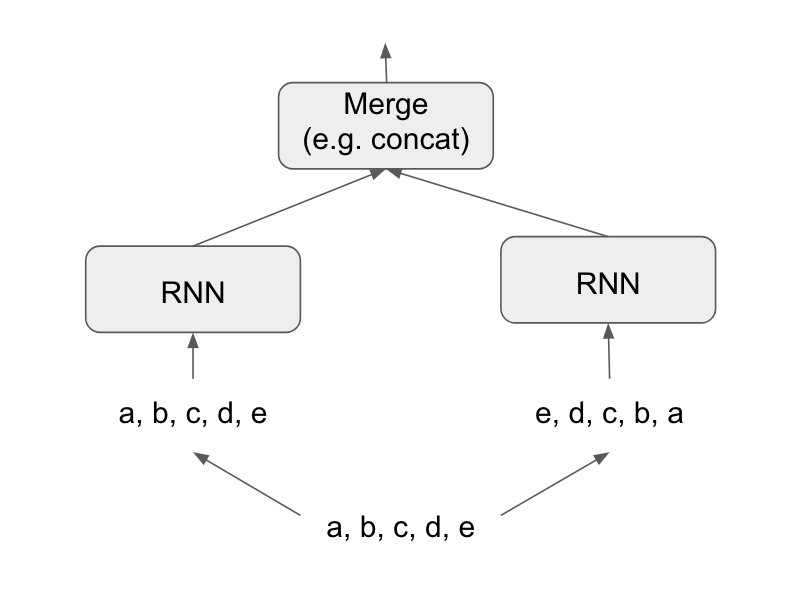

In [22]:
from IPython.display import Image
 
Image("./bidirectionalrnn.png")

케라스에서는 Bidirectional 층을 사용하여 양방향 RNN을 만듭니다. 이 클래스는 첫 번째 매개변수로 순환 층의 객체를 전달받습니다. Bidirectional 클래스는 전달받은 순환 층으로 새로운 두 번째 객체를 만듭니다. 하나는 시간 순서대로 입력 시퀀스를 처리하고 다른 하나는 반대 순서로 입력 시퀀스를 처리합니다. IMDB 감성 분석 문제에 적용해 보겠습니다.

In [0]:
# 코드 6-43 양방향 LSTM을 훈련하고 평가하기
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

검증 정확도는 88% 정도로 이전 절에서 사용했던 일반 LSTM보다 조금 더 성능이 높습니다. 양방향 순환 층이 단방향 LSTM보다 모델 파라미터가 2배 많기 때문에 더 일찍 오버피팅되는 것 같습니다. 이제 온도 예측 문제에 적용하겠습니다.

In [0]:
코드 6-44 양방향 GRU 훈련하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

일반 GRU 층과 비슷한 성능을 냅니다. 왜냐하면 모든 예측 성능은 시간 순서대로 처리하는 네트워크에서 오는데 시간 반대 순서는 이런 작업이 적절하지 않기 때문입니다.

### 6.3.9 더 나아가서

온도 예측 문제의 성능을 향상하기 위해 시도해 볼 것들입니다.
* 스태킹한 각 순환 층의 유닛 수 조정
* RMSprop 옵티마이저가 사용한 학습률 조정
* GRU 대신 LSTM 층 사용
* 순환 층 위에 용량이 큰 완전 연결된 회귀 층(유닛 수가 많은 Dense나 Dense 스태킹) 사용
* 최종적으로 최선의 모델을 테스트 세트에서 확인(안그럼 검증 세트에 오버피팅된 네트워크 구조를 만듬)

### 6.3.10 정리

* 새로운 문제를 해결할 때는 선택한 지표에서 상식 수준의 기준점을 설정하는 것이 좋습니다.
* 계산 비용을 판단하기 위해 비용이 비싼 모델 전 간단한 모델을 시도합니다.
* 시간 순서가 중요한 데이터가 있으면 순환 층이 적합합니다.
* 순환 네트워크에 드롭아웃을 사용하려면 타임스텝 동안 일정한 드롭아웃 마스크와 순환 드롭아웃 마스크를 사용해야 합니다.
* 스태킹 RNN은 단일 RNN보다 복잡한 문제에서 더 강력한 표현 능력을 제공합니다.
* 양방향 RNN은 자연어 처리 문제에 유용하지만 최근 정보가 오래된 정보보다 더 의미있는 시퀀스 데이터에는 잘 작동하지 않습니다.

# 6.4 컨브넷을 사용한 시퀀스 처리

**1D 컨브넷(1D Convnet)** 은 특정 시퀀스 처리 문제에 RNN과 견줄 만합니다. 일반적으로 계산 비용이 훨씬 쌉니다. 1D 컨브넷은 전형적으로 팽창된 커널과 함께 사용됩니다. 텍스트 분류나 시계열 예측 같은 간단한 문제에서는 RNN을 대신하여 빠르게 처리할 수 있다고 알려져있습니다.

### 6.4.1 시퀀스 데이터를 위한 1D 합성곱 이해하기

앞서 소개한 합성곱 층은 2D 합성곱입니다. 이미지 텐서에서 2D 패치를 추출하고 모든 패치에 동일한 변환을 적용합니다. 같은 방식으로 시퀀스에서 1D를 추출하여 1D 합성곱을 적용합니다.

이런 1D 합성곱 층은 시퀀스에 있는 지역 패턴을 인식할 수 있습니다. 동일한 변환이 시퀀스에 있는 모든 패치에 적용되기 때문에 특정 위치에서 학습한 패턴을 나중에 다른 위치에서 인식할 수 있습니다. 이는 1D 컨브넷에 시간의 이동에 대한 이동 불변성을 제공합니다.

### 6.4.2 시퀀스 데이터를 위한 1D 풀링

컨브넷에서 이미지 텐서의 크기를 다운 샘플링하기 위해 사용하는 평균 풀링이나 맥스 풀링 같은 2D 풀링 연산을 배웠습니다. 1D 풀링 연산은 2D 풀링 연산과 동일합니다. 입력에서 1D 패치(부분 시퀀스)를 추출하고 풀링으로 출력합니다. 1D 입력의 길이를 줄이기 위해 사용합니다.(**서브샘플링(subsampling)**)

### 6.4.3 1D 컨브넷 구현

케라스에서 1D 컨브넷은 Conv1D 층을 사용하여 구현합니다. (samples, time, features) 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다.

간단한 2개의 층으로 된 1D 컨브넷을 만들어 IMDB 감성 분류 문제에 적용해봅니다. 데이터 로드 및 전처리는 이전에 사용한 코드를 그대로 사용합니다.

In [1]:
# 코드 6-45 IMDB 데이터 전처리하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

Using TensorFlow backend.


데이터 로드...
17465344/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


2D 컨브넷과 비슷하나 한가지 다른 점은 1D 컨브넷에 큰 합성곱 윈도우(7이나 9)를 사용할 수 있습니다.

In [2]:
# 코드 6-46 IMDB 데이터에 1D 컨브넷을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

W0830 06:14:10.168663 140302143072128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 06:14:10.184551 140302143072128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 06:14:10.186948 140302143072128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 06:14:10.234941 140302143072128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0830 06:14:10.286028 140302143072128 deprecation_wrapp

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

W0830 06:14:10.571509 140302143072128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 315us/step - loss: 0.8206 - acc: 0.5054 - val_loss: 0.6940 - val_acc: 0.5004
Epoch 2/10
20000/20000 [==============================] - 3s 150us/step - loss: 0.6774 - acc: 0.6134 - val_loss: 0.6800 - val_acc: 0.6108
Epoch 3/10
20000/20000 [==============================] - 3s 150us/step - loss: 0.6511 - acc: 0.7541 - val_loss: 0.6598 - val_acc: 0.6858
Epoch 4/10
20000/20000 [==============================] - 3s 148us/step - loss: 0.6084 - acc: 0.8132 - val_loss: 0.6081 - val_acc: 0.7420
Epoch 5/10
20000/20000 [==============================] - 3s 149us/step - loss: 0.5156 - acc: 0.8339 - val_loss: 0.4947 - val_acc: 0.7964
Epoch 6/10
20000/20000 [==============================] - 3s 149us/step - loss: 0.4028 - acc: 0.8565 - val_loss: 0.4170 - val_acc: 0.8400
Epoch 7/10
20000/20000 [==============================] - 3s 150us/step - loss: 0.3320 - acc: 0.8751 - val_loss: 0.3972 - v

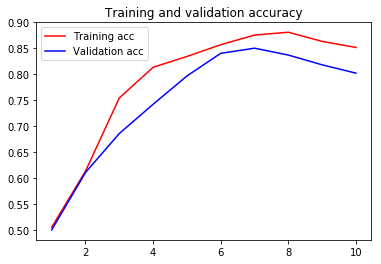

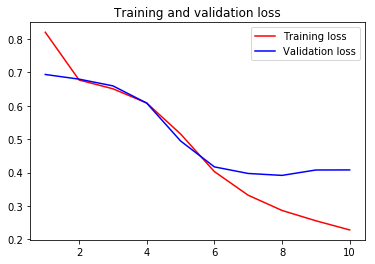

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도는 LSTM보다 조금 낮지만 CPU나 GPU에서 더 빠르게 실행됩니다. 이 예는 단어 수준의 감성 분류 작업에 순환 네트워크를 대신하여 빠르고 경제적인 1D 컨브넷을 사용할 수 있음을 보여줍니다.

### 6.4.4 CNN과 RNN을 연결하여 긴 시퀀스를 처리하기

1D 컨브넷이 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 타임스텝의 순서에 민감하지 않습니다. 물론 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수는 있지만 순서를 감지하기에 부족합니다.

앞서 다뤄본 온도 예측 문제에 1D 컨브넷을 적용해보겠습니다.

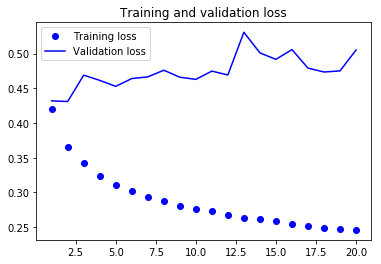

In [5]:
from IPython.display import Image
 
Image("./conv1dtemp.png")

앞의 코드는 생략을 했습니다. 그래프를 보면 검증 MAE는 0.40대에 머물러 있습니다. 작은 컨브넷을 사용해서 상식 수준의 기준점을 넘지 못했습니다.


이유는 컨브넷이 시간 순서를 고려하지 않기 때문입니다.

컨브넷의 속도와 경량함을 RNN의 순서 감지 능력과 결합하는 한 가지 전략은 1D 컨브넷을 RNN 이전의 전처리 단계로 사용하는 것입니다. 수천 개의 스텝을 가진 시퀀스 같이 RNN으로 처리하기에는 긴 시퀀스를 다룰 때 유용합니다. 이 기법이 연구 논문이나 실전 애플리케이션에 자주 등장하지는 않습니다. 아마도 널리 알려지지 않았기 때문일 것입니다.

이 기법을 사용하면 훨씬 긴 시퀀스를 다룰 수 있으므로 더 오래전 데이터를 바라보거나, 시계열 데이터를 더 촘촘히 바라볼 수 있습니다.

In [0]:
# 코드 6-48 고밀도 데이터 제너레이터로 예나 데이터셋 준비하기

# 이전에는 6이었습니다(시간마다 1 포인트); 이제는 3 입니다(30분마다 1 포인트)
step = 3
lookback = 1440  # 변경 안 됨
delay = 144 # 변경 안 됨

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

이 모델은 2개의 Conv1D 층 다음에 GRU 층을 놓았습니다.

In [0]:
# 코드 6-49 1D 합성곱과 GRU 층을 연결한 모델
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

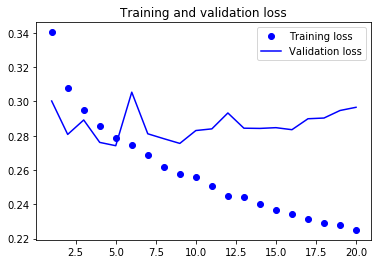

In [8]:
from IPython.display import Image
 
Image("./conv1dgru.png")

검증 손실로 보면 이 설정은 규제가 있는 GRU 모델만큼 좋지는 않습니다. 하지만 훨씬 빠르기에 데이터를 2배 더 많이 처리할 수 있고, 다른 문제에는 중요할 수 있습니다.

### 6.4.5 정리

* 2D 컨브넷이 2D 공간의 시각적 패턴을 잘 처리하는 것처럼 1D 컨브넷도 시간에 따른 패턴을 잘 처리합니다.
* RNN으로 긴 시퀀스를 처리하려면 계산 비용이 많이 들지만 1D 컨브넷은 비용이 적게 듭니다.

## 6.5 요약

배운 기법들
* 텍스트를 토큰화하는 방법
* 단어 임베딩과 이를 사용하는 방법
* 순환 네트워크와 이를 사용하는 방법
* 더 강력한 시퀀스 처리 모델을 만들기 위해 RNN 층을 스태킹하는 방법과 양방향 RNN을 사용하는 방법
* 1D 컨브넷을 사용하는 방법